In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/MyDrive/Colab Notebooks/동서발전 태양광 발전량 예측 경진대회/data.zip" "data.zip"
# data.zip을 현재 디렉터리에 압축해제
!unzip "data.zip"
output.clear()

import os

In [25]:

# path
path = "./"
dangjin_fcst_data_path = path + "dangjin_fcst_data.csv"
dangjin_obs_data_path = path + "dangjin_obs_data.csv"
energy_data_path = path + "energy.csv"
ulsan_fcst_data_path = path + "ulsan_fcst_data.csv"
ulsan_obs_data_path = path + "ulsan_obs_data.csv"
site_info_path = path + "site_info.csv"

# import library 
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import glob

# file convert to pandas data
dangjin_fcst_data = pd.read_csv(dangjin_fcst_data_path)
dangjin_obs_data = pd.read_csv(dangjin_obs_data_path)
energy_data = pd.read_csv(energy_data_path)
ulsan_fcst_data = pd.read_csv(ulsan_fcst_data_path)
ulsan_obs_data = pd.read_csv(ulsan_obs_data_path)
site_info = pd.read_csv(site_info_path)


# ======================================================================== #
# =========================== 이하는 공통 사항  =========================== #
# ======================================================================== #

'''
- 일자, 시각 등은 'time' 이라는 변수명으로 통일
- 그 외의 변수명은 '변수명_파일명' 으로 지정(ulsan, dangjin)
- 가정하길 ulsan 데이터와 dangjin 데이터는 서로 무관하다. 
- 이후에 NAN 데이터는 dropna()를 이용해 모두 소거 예정
- 하나의 데이터셋을 구축한 뒤, 상관관게 분석 + ADF test 등을 진행
'''

dangjin_fcst_data.rename(
    columns = {
        "Forecast time":"time", 
        "forecast":"forecast_fcst", 
        "Temperature":"temp_fcst",
        "Humidity":"humid_fcst",
        "WindSpeed":"ws_fcst",
        "WindDirection":"wd_fcst",
        "Cloud":"cloud_fcst"
        }, inplace = True)

dangjin_obs_data.rename(
    columns = {
        "일시":"time",
        "기온(°C)":"temp_obs",
        "풍속(m/s)":"ws_obs",
        "풍향(16방위)":"wd_obs",
        "습도(%)":"humid_obs",
        "전운량(10분위)":"cloud_obs"
    }, inplace = True)

ulsan_fcst_data.rename(
    columns = {
        "Forecast time":"time", 
        "forecast":"forecast_fcst", 
        "Temperature":"temp_fcst",
        "Humidity":"humid_fcst",
        "WindSpeed":"ws_fcst",
        "WindDirection":"wd_fcst",
        "Cloud":"cloud_fcst"
    }, inplace = True)

ulsan_obs_data.rename(
    columns = {
        "일시":"time",
        "기온(°C)":"temp_obs",
        "풍속(m/s)":"ws_obs",
        "풍향(16방위)":"wd_obs",
        "습도(%)":"humid_obs",
        "전운량(10분위)":"cloud_obs"
    }, inplace = True)

dangjin_obs_data = dangjin_obs_data.drop(columns = ["지점", "지점명"])
ulsan_obs_data = ulsan_obs_data.drop(columns = ["지점","지점명"])

# fcst_data 데이터 전처리
# time + forecast -> time으로 전환, 이후 중복되는 값은 평균 처리 

dangjin_fcst_data["time_fcst"] = pd.to_datetime(dangjin_fcst_data["time"].copy()) + dangjin_fcst_data["forecast_fcst"].copy().astype("timedelta64[h]")
dangjin_fcst_data = dangjin_fcst_data.groupby("time_fcst", as_index = False).mean()
dangjin_fcst_data = dangjin_fcst_data.drop(columns = ["forecast_fcst"])

ulsan_fcst_data["time_fcst"] = pd.to_datetime(ulsan_fcst_data["time"].copy()) + ulsan_fcst_data["forecast_fcst"].copy().astype("timedelta64[h]")
ulsan_fcst_data = ulsan_fcst_data.groupby("time_fcst", as_index = False).mean()
ulsan_fcst_data = ulsan_fcst_data.drop(columns = ["forecast_fcst"])

ulsan_fcst_data.rename(columns = {"time_fcst":"time"}, inplace = True)
dangjin_fcst_data.rename(columns = {"time_fcst":"time"}, inplace = True)

ulsan_fcst_data = ulsan_fcst_data.astype({"time":"object"})
dangjin_fcst_data = dangjin_fcst_data.astype({"time":"object"})

dangjin_obs_data["time"] = pd.to_datetime(dangjin_obs_data["time"].copy(), format='%Y-%m-%d %H:%M:%S')
dangjin_obs_data = dangjin_obs_data.astype({"time":"object"})

ulsan_obs_data["time"] = pd.to_datetime(ulsan_obs_data["time"].copy(), format='%Y-%m-%d %H:%M:%S')
ulsan_obs_data = ulsan_obs_data.astype({"time":"object"})

# energy_data는 time 항목이 string으로 저장되어 있다. 이를 timestamp로 처리해야한다. 

import datetime as dt

energy_data_time_tmp = energy_data["time"].copy()

for i in range(energy_data.shape[0]):
    if energy_data["time"][i][-8:] == "24:00:00":
        energy_data["time"][i] = energy_data_time_tmp[i].replace("24:00:00", " 00:00:00")
        energy_data["time"][i] = pd.to_datetime(energy_data["time"][i]) + dt.timedelta(days = 1)

    energy_data["time"][i] = pd.Timestamp(energy_data["time"][i])

energy_data = energy_data.astype({"time":"object"})

# 전 데이터 NAN 처리

'''
dangjin_fcst_data = dangjin_fcst_data.dropna()
dangjin_obs_data = dangjin_obs_data.dropna()
energy_data = energy_data.dropna()
ulsan_fcst_data = ulsan_fcst_data.dropna()
ulsan_obs_data = ulsan_obs_data.dropna()
'''

dangjin_fcst_data = dangjin_fcst_data.fillna(method = "bfill")
dangjin_obs_data = dangjin_obs_data.fillna(method = "bfill")
energy_data = energy_data.fillna(method = "bfill")
ulsan_fcst_data = ulsan_fcst_data.fillna(method = "bfill")
ulsan_obs_data = ulsan_obs_data.fillna(method = "bfill")

# fcst_data['time'] time interval: 3hour -> 1hour로 축소 필요
# Lagrangian Interpolation

def interpolation(df):

    df_copy = df.copy()
    var_names = df.columns

    total_s = list()
    time_list = list()
    
    for var_name in var_names:
        s = list()
        for i in range(df_copy.shape[0] - 1):
            timedeltas = df_copy["time"][i+1] - df_copy["time"][i]
            n_intervals = int(timedeltas / np.timedelta64(1, "h"))

            for j in range(n_intervals):
        
                if var_name == "time":
                    time_stamps = df_copy["time"][i] + timedeltas * j / n_intervals
                    time_list.append(time_stamps)
                else:
                    add_ = df_copy[var_name][i] + (df_copy[var_name][i+1] - df_copy[var_name][i]) / n_intervals * j
                    s.append(add_)

        if var_name == "time":
            time_list = np.array(time_list).reshape(-1,1)
            total_s.append(time_list)
        else:
            s = np.array(s).reshape(-1,1)
            total_s.append(s)

    total_s = np.array(total_s).T.reshape(-1, len(var_names))
    df_converted = pd.DataFrame(total_s, columns = var_names)

    return df_converted

dangjin_fcst_data = interpolation(dangjin_fcst_data.copy())
ulsan_fcst_data = interpolation(ulsan_fcst_data.copy())

ulsan_fcst_data = ulsan_fcst_data.astype({"time":"object"})
dangjin_fcst_data = dangjin_fcst_data.astype({"time":"object"})
energy_data = energy_data.astype({"time":"object"})
dangjin_obs_data = dangjin_obs_data.astype({"time":"object"})
ulsan_obs_data = ulsan_obs_data.astype({"time":"object"})

# total dataset 구성

from functools import reduce

list_dangjin = [dangjin_fcst_data, dangjin_obs_data, energy_data[["time","dangjin_floating","dangjin_warehouse","dangjin"]].copy()]
list_ulsan = [ulsan_fcst_data, ulsan_obs_data, energy_data[["time","ulsan"]].copy()]

dangjin_data = reduce(lambda  left,right: pd.merge(left, right, on=['time'], how='inner'), list_dangjin)
ulsan_data = reduce(lambda  left,right: pd.merge(left, right, on=['time'], how='inner'), list_ulsan)

# supervised learning을 위한 preprocessing

def series_to_supervised(data, x_name, y_name, n_in, n_out, dropnan = False):

    '''
    - function: to convert series data to be supervised 
    - data: pd.DataFrame
    - x_name: the name of variables used to predict
    - y_name: the name of variables for prediction
    - n_in: number(or interval) of series used to predict
    - n_out: number of series for prediction

    - 24 * 30 -> 720개의 output을 예측
    - 필요한 input -> 최소 720개 이상
    - 아이디어: 1일 예측, 예측치를 다시 입력값으로 받게 진행, 이 경우 output:24

    '''

    data_copy = data.copy()
    cols, names = list(), list()


    for i in range(n_in, 0, -1):
        cols.append(data_copy[x_name].shift(i))
        names += [("%s(t-%d)"%(name, i)) for name in x_name]
    
    for i in range(0, n_out):
        y = data_copy[y_name]
        cols.append(y.shift(-i))
        # cols:[data_copy.shift(n_in-1), .... data_copy.shift(1), data_copy[y_name].shift(0)....data_copy[y_name].shift(-n_out + 1)]

        if i == 0:
            names += [("%s(t)"%(name)) for name in y_name]
        else:
            names += [("%s(t+%d)"%(name, i)) for name in y_name]

    agg = pd.concat(cols, axis = 1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace = True)
    
    return agg

# model architecture

#!sudo pip install xgboost
#!sudo pip install --upgrade xgboost

import xgboost as xgb

'''
- input data와 output data의 timesteps 조정
- 입력값은 예측하고자 하는 변수를 그대로 적용
'''

# dangjin floating
x_name = ["dangjin_floating"]
y_name = ["dangjin_floating"]
n_features = len(x_name)
n_in = 24 * 7
n_out = 1
ratio = 0.8 # train size ratio

dangjin_data_supervised = series_to_supervised(dangjin_data, x_name, y_name, n_in, n_out, dropnan = True)

x_data = dangjin_data_supervised.values[:,:-n_out * len(y_name)]
y_data = dangjin_data_supervised.values[:,-n_out * len(y_name):]

# train_test split
data_size = x_data.shape[0]
train_size = int(data_size * ratio)

x_train = x_data[0:train_size]
x_test = x_data[train_size:]

y_train = y_data[0:train_size]
y_test = y_data[train_size:]

# build model
params = {
    "booster":"dart",
    "objective":"reg:pseudohubererror",
    "learning_rate":0.1,
    "max_depth":12,
    "n_estimators":500,
    "nthread":-1,
    "gamma":1.0,
    "subsample":1.0,
    "colsample_bytree":1.0,
    "colsample_bylevel":1.0,
    "min_child_weight":3,
    "reg_lambda":1.0,
    "reg_alpha":0.1,
}

# build model and parameter setting

def build_xgb(params):
    model = xgb.XGBRegressor(
        booster = params["booster"],
        objective = params["objective"],
        learning_rate = params["learning_rate"],    
        max_depth = params["max_depth"],
        n_estimators = params["n_estimators"],
        nthread = params["nthread"],
        gamma = params["gamma"],
        min_child_weight = params["min_child_weight"],
        subsample = params["subsample"],
        reg_lambda = params["reg_lambda"],
        reg_alpha = params["reg_alpha"],
        colsample_bytree = params["colsample_bytree"],
        colsample_bylevel = params["colsample_bylevel"],
    )
    return model

model = build_xgb(params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
model.fit(x_train, y_train, early_stopping_rounds = 200, eval_set = [(x_test, y_test)])

[0]	validation_0-mphe:71.53834
[1]	validation_0-mphe:57.93969
[2]	validation_0-mphe:49.61840
[3]	validation_0-mphe:43.42197
[4]	validation_0-mphe:39.50061
[5]	validation_0-mphe:35.90298
[6]	validation_0-mphe:33.48577
[7]	validation_0-mphe:31.64855
[8]	validation_0-mphe:29.61900
[9]	validation_0-mphe:27.97355
[10]	validation_0-mphe:26.45812
[11]	validation_0-mphe:25.56421
[12]	validation_0-mphe:24.71214
[13]	validation_0-mphe:24.10937
[14]	validation_0-mphe:23.57894
[15]	validation_0-mphe:23.22157
[16]	validation_0-mphe:22.90457
[17]	validation_0-mphe:22.62677
[18]	validation_0-mphe:22.39382
[19]	validation_0-mphe:22.18739
[20]	validation_0-mphe:21.94902
[21]	validation_0-mphe:21.77655
[22]	validation_0-mphe:21.68198
[23]	validation_0-mphe:21.55651
[24]	validation_0-mphe:21.40435
[25]	validation_0-mphe:21.32464
[26]	validation_0-mphe:21.22403
[27]	validation_0-mphe:21.16871
[28]	validation_0-mphe:21.08214
[29]	validation_0-mphe:20.99406
[30]	validation_0-mphe:20.94800
[31]	validation_0-

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=1.0, gamma=1.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=12,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=-1, num_parallel_tree=1,
             objective='reg:pseudohubererror', random_state=0, reg_alpha=0.1,
             reg_lambda=1.0, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

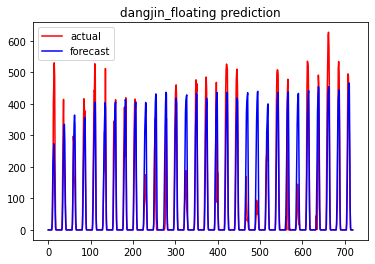

In [27]:
# submission_prediction

def submission_predict(models, x_data, n_predict):
    '''
    - for multi-varaible prediction
    - x_data:(timesteps, n_features)
    - n_predict: timesteps for forecasting
    - x_data_after: x_data[1:] + predict_value
    '''
    total_prediction = None
    y_preds = []
    x_data_after = x_data

    for i in range(n_predict):
        y_preds = []
        for j in range(n_features):
            y_pred = models[j].predict(x_data_after)
            y_preds.append(y_pred)

        y_preds = np.array(y_preds).reshape(1,-1)
        x_data_after = np.concatenate((x_data_after, y_preds), axis = 1)[0,n_features:].reshape(1,-1)
        

        if total_prediction is None:
            total_prediction = y_preds
        else:
            total_prediction = np.concatenate((total_prediction, y_preds), axis = 0)
    
    total_prediction = total_prediction.reshape(-1, n_features)

    return total_prediction

# test
input_prediction = dangjin_data[x_name][-24*30*1 - n_in:-24*30*1].values.reshape(1,-1)
actual = dangjin_data[y_name][-24*30*1:].values
prediction = submission_predict([model], input_prediction, n_predict = 24 * 30)

plt.title("dangjin_floating prediction")
yreal = actual.reshape(-1,1)
yhat = prediction.reshape(-1, 1)
plt.plot(yreal, "r", label = "actual")
plt.plot(yhat, "b", label = "forecast")
plt.legend()
plt.show()